In [1]:
#!/usr/bin/env python3

# NOTE

- This file relies on the files downloaded and parsed by Download_data_DTH.ipynb
- Next, I can continue taking stuff from the 1_SRO_consumption_and_basic_devaluation_v4.ipynb in this folder, and taing stuff from the other files in the original project.

## General settings

In [8]:
#@title Import stuff and general settings
import numpy as np
import pandas as pd
import collections
import firebase_admin
from firebase_admin import credentials, firestore
import math
import os
import json
import datetime
from datetime import date, datetime

import matplotlib.pyplot as plt
import seaborn as sns




# Read Data

In [4]:
# read data:
main_data_df = pd.read_pickle('parsed_data/main_data_df.pkl')
CT_data = pd.read_pickle('parsed_data/CT_data.pkl')
gambles = pd.read_pickle('parsed_data/gambles.pkl')

In [6]:
main_data_df['sub'].unique()

array([101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 112, 113, 114])

# Analyze basic stuff

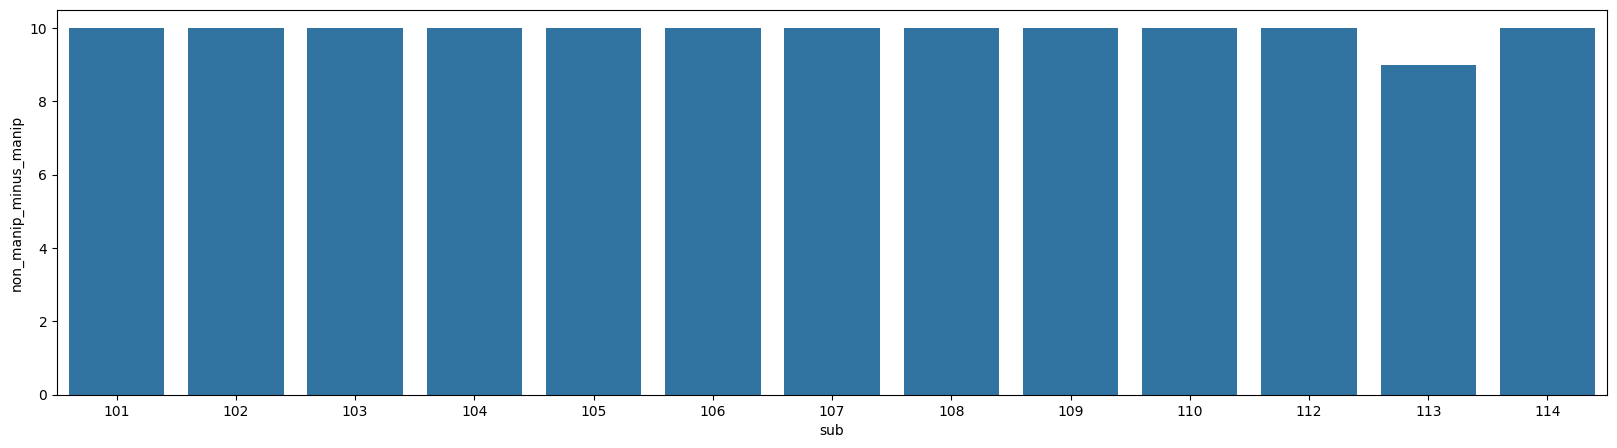

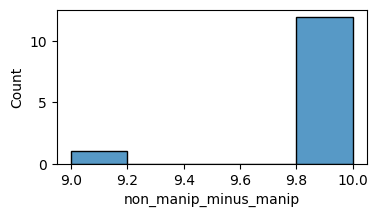

In [38]:
CT_data

# barplot CT_data by sub:
# -----------------------------
# make a figure with two plot vertically:
# make a wide 1 figure:
fig, axs = plt.subplots(1, 1, figsize=(20, 5), sharey=True)
sns.barplot(x='sub', y='non_manip_minus_manip', data=CT_data, ax=axs)
plt.show()
# draw a histogrma of CT_data of the non_manip_minus_manip:
fig, axs = plt.subplots(1, 1, figsize=(4, 2), sharey=True)
sns.histplot(data=CT_data, x='non_manip_minus_manip')
plt.show()



In [30]:
CT_data

,sub,group,block,trial,manipulation_stim,manipulation,blue,red,ice,rock,misses,non_manip_minus_manip
0,101,extensive,2,21,NaN,NaN,8,9,0,0,0,NaN
1,101,extensive,11,33,red,devaluation,10,0,6,0,0,10.0
2,102,extensive,2,21,NaN,NaN,5,8,0,0,0,NaN
3,102,extensive,11,33,blue,devaluation,0,10,0,0,0,10.0
4,103,extensive,2,21,NaN,NaN,10,10,4,0,0,NaN
5,103,extensive,11,33,red,devaluation,10,0,0,0,0,10.0
6,104,extensive,2,21,NaN,NaN,7,9,0,0,1,NaN
7,104,extensive,11,33,blue,devaluation,0,10,1,0,0,10.0
8,105,extensive,2,21,NaN,NaN,6,5,6,0,0,NaN
9,105,extensive,11,33,red,devaluation,10,0,4,0,0,10.0


/var/folders/h_/4yn2bj6118x8bmpj49gssb440000gn/T/ipykernel_7367/639256814.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[j].set_xticklabels(axs[j].get_xticklabels(), rotation=90)
/var/folders/h_/4yn2bj6118x8bmpj49gssb440000gn/T/ipykernel_7367/639256814.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[j].set_xticklabels(axs[j].get_xticklabels(), rotation=90)


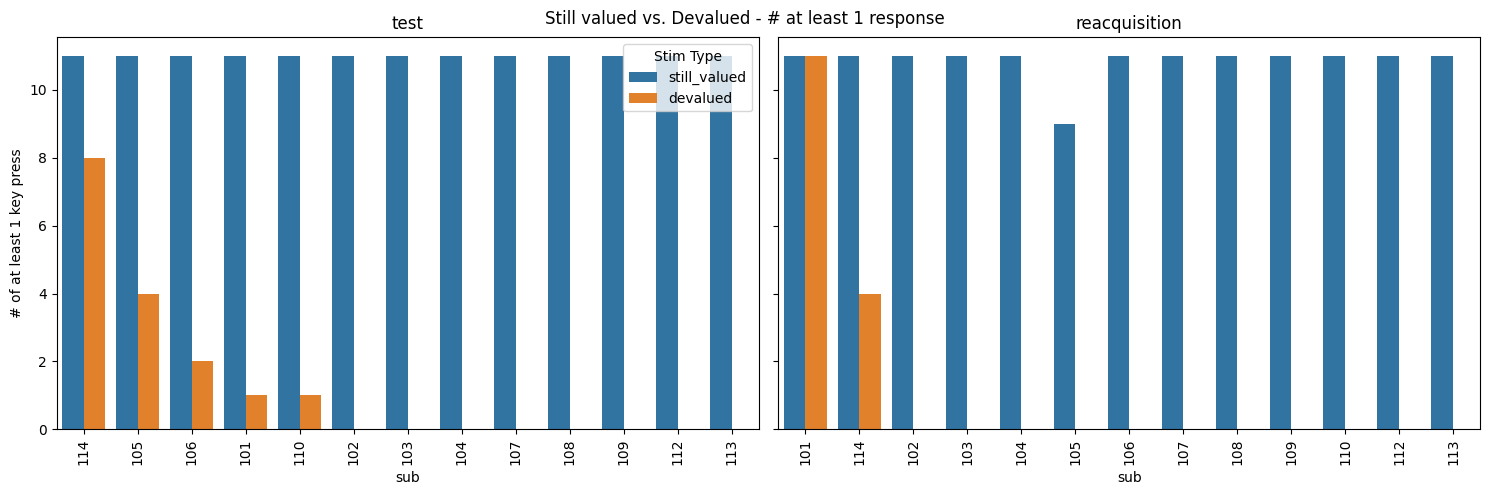

In [18]:
deval_data = main_data_df[main_data_df['phase'].notnull()]
deval_data = deval_data[deval_data['stim_condition'] != 'never_valued']
deval_data['phase'] = deval_data['phase'].astype(str)

deval_data_summary = deval_data.groupby(['sub', 'phase', 'stim_condition'])['SRO_rt_of_SRO_key'].count()
# deval_data_summary = deval_data_summary.unstack(level=3)
deval_data_summary = deval_data_summary.reset_index()

deval_data_summary[deval_data_summary['phase'] == 'test']

# make a figure with two plot vertically:
fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
for j, phase in enumerate(['test', 'reacquisition']):
    data_to_plot = deval_data_summary[(deval_data_summary['phase'] == phase)]
    order = data_to_plot[data_to_plot.stim_condition == 'devalued'].sort_values(by='SRO_rt_of_SRO_key', ascending=False)['sub'].unique()
    # plot the data with a bar for each condition for each sub ()use sub for the xticks (make zticks vertical and fit):
    sns.barplot(x='sub', y='SRO_rt_of_SRO_key', hue='stim_condition', hue_order=['still_valued', 'devalued'], data=data_to_plot, order=order, ax=axs[j])
    # make xticks vertical and fit:
    axs[j].set_title(phase)
    # add a label to the y axis:
    axs[j].set_ylabel('# of at least 1 key press')
    axs[j].legend_.remove()
    axs[j].set_xticklabels(axs[j].get_xticklabels(), rotation=90)

axs[0].legend(title='Stim Type')

# use tight layout:
fig.tight_layout()

# add a title to the figure:
fig.suptitle('Still valued vs. Devalued - # at least 1 response')

# show the figure:
plt.show()

/var/folders/h_/4yn2bj6118x8bmpj49gssb440000gn/T/ipykernel_7367/433525056.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.set_xticklabels(axs.get_xticklabels(), rotation=90)


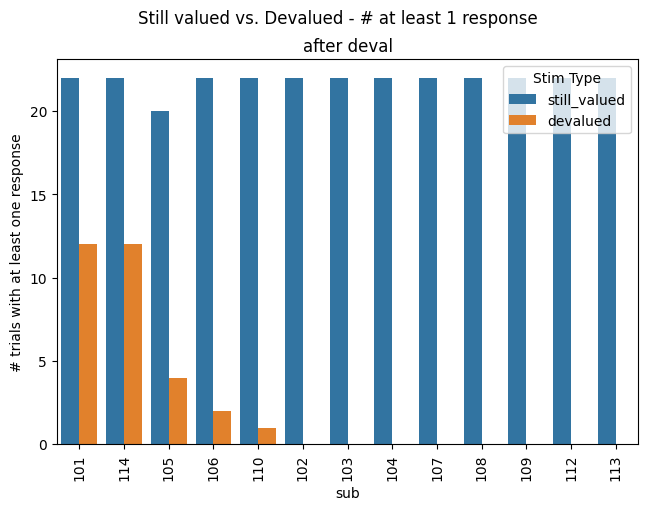

In [26]:
deval_data = main_data_df[main_data_df['phase'].notnull()]
deval_data = deval_data[deval_data['stim_condition'] != 'never_valued']
deval_data['phase'] = deval_data['phase'].astype(str)

deval_data.loc[deval_data['phase'] == 'pre_test','phase'] = 'before'
deval_data.loc[(deval_data['phase'] == 'test') | (deval_data['phase'] == 'reacquisition'),'phase'] = 'after'

deval_data_summary = deval_data.groupby(['sub', 'phase', 'stim_condition'])['SRO_rt'].count()
# deval_data_summary = deval_data_summary.unstack(level=3)
deval_data_summary = deval_data_summary.reset_index()

deval_data_summary[deval_data_summary['phase'] == 'test']

# make a figure with two plot vertically:
fig, axs = plt.subplots(1, 1, figsize=(7.5, 5), sharey=True)
i=0
data_to_plot = deval_data_summary[(deval_data_summary['phase'] == 'after')]
order = data_to_plot[data_to_plot.stim_condition == 'devalued'].sort_values(by='SRO_rt', ascending=False)['sub'].unique()
# plot the data with a bar for each condition for each sub ()use sub for the xticks (make zticks vertical and fit):
sns.barplot(x='sub', y='SRO_rt', hue='stim_condition', hue_order=['still_valued', 'devalued'], data=data_to_plot, order=order, ax=axs)
# make xticks vertical and fit:
axs.set_title('after deval')
# add a label to the y axis:
axs.set_ylabel('# trials with at least one response')
axs.legend_.remove()
# make xticks include only last two digits of sub:
axs.set_xticklabels(axs.get_xticklabels(), rotation=90)

axs.legend(title='Stim Type')

# use tight layout:
# fig.tight_layout(pad=3.0)

# add a title to the figure:
fig.suptitle('Still valued vs. Devalued - # at least 1 response')

# show the figure:
plt.show()

